---

# **CSCI485 Assignment#1: RFE with Linear Regression**

Author: Jacob Collins

---

## Task 1: Dataset Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# Some helper functions I have written
from fig_helpers import compareLines, compareScatter

In [3]:
# Step 1. Load diabetes dataset
diabetes = load_diabetes()
features = diabetes.feature_names
X = pd.DataFrame(diabetes.data, columns=features)
y = diabetes.target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Step 2. Describe the features and target variables.
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [5]:
# Step 3. Split the dataset into training and testing sets using an 80-20 split.
np.random.seed(40)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2)
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)
n_training = len(X_train)
n_testing = len(X_test)
n_total = n_training + n_testing
print(f'There are {n_training} training records and {n_testing} testing records.\n' + 
      f'{np.round(n_training*100/n_total,2)}% Training\n' +
      f'{np.round(n_testing*100/n_total,2)}% Testing')


There are 353 training records and 89 testing records.
79.86% Training
20.14% Testing


## Task 2: Linear Regression Model

R^2: 0.3512


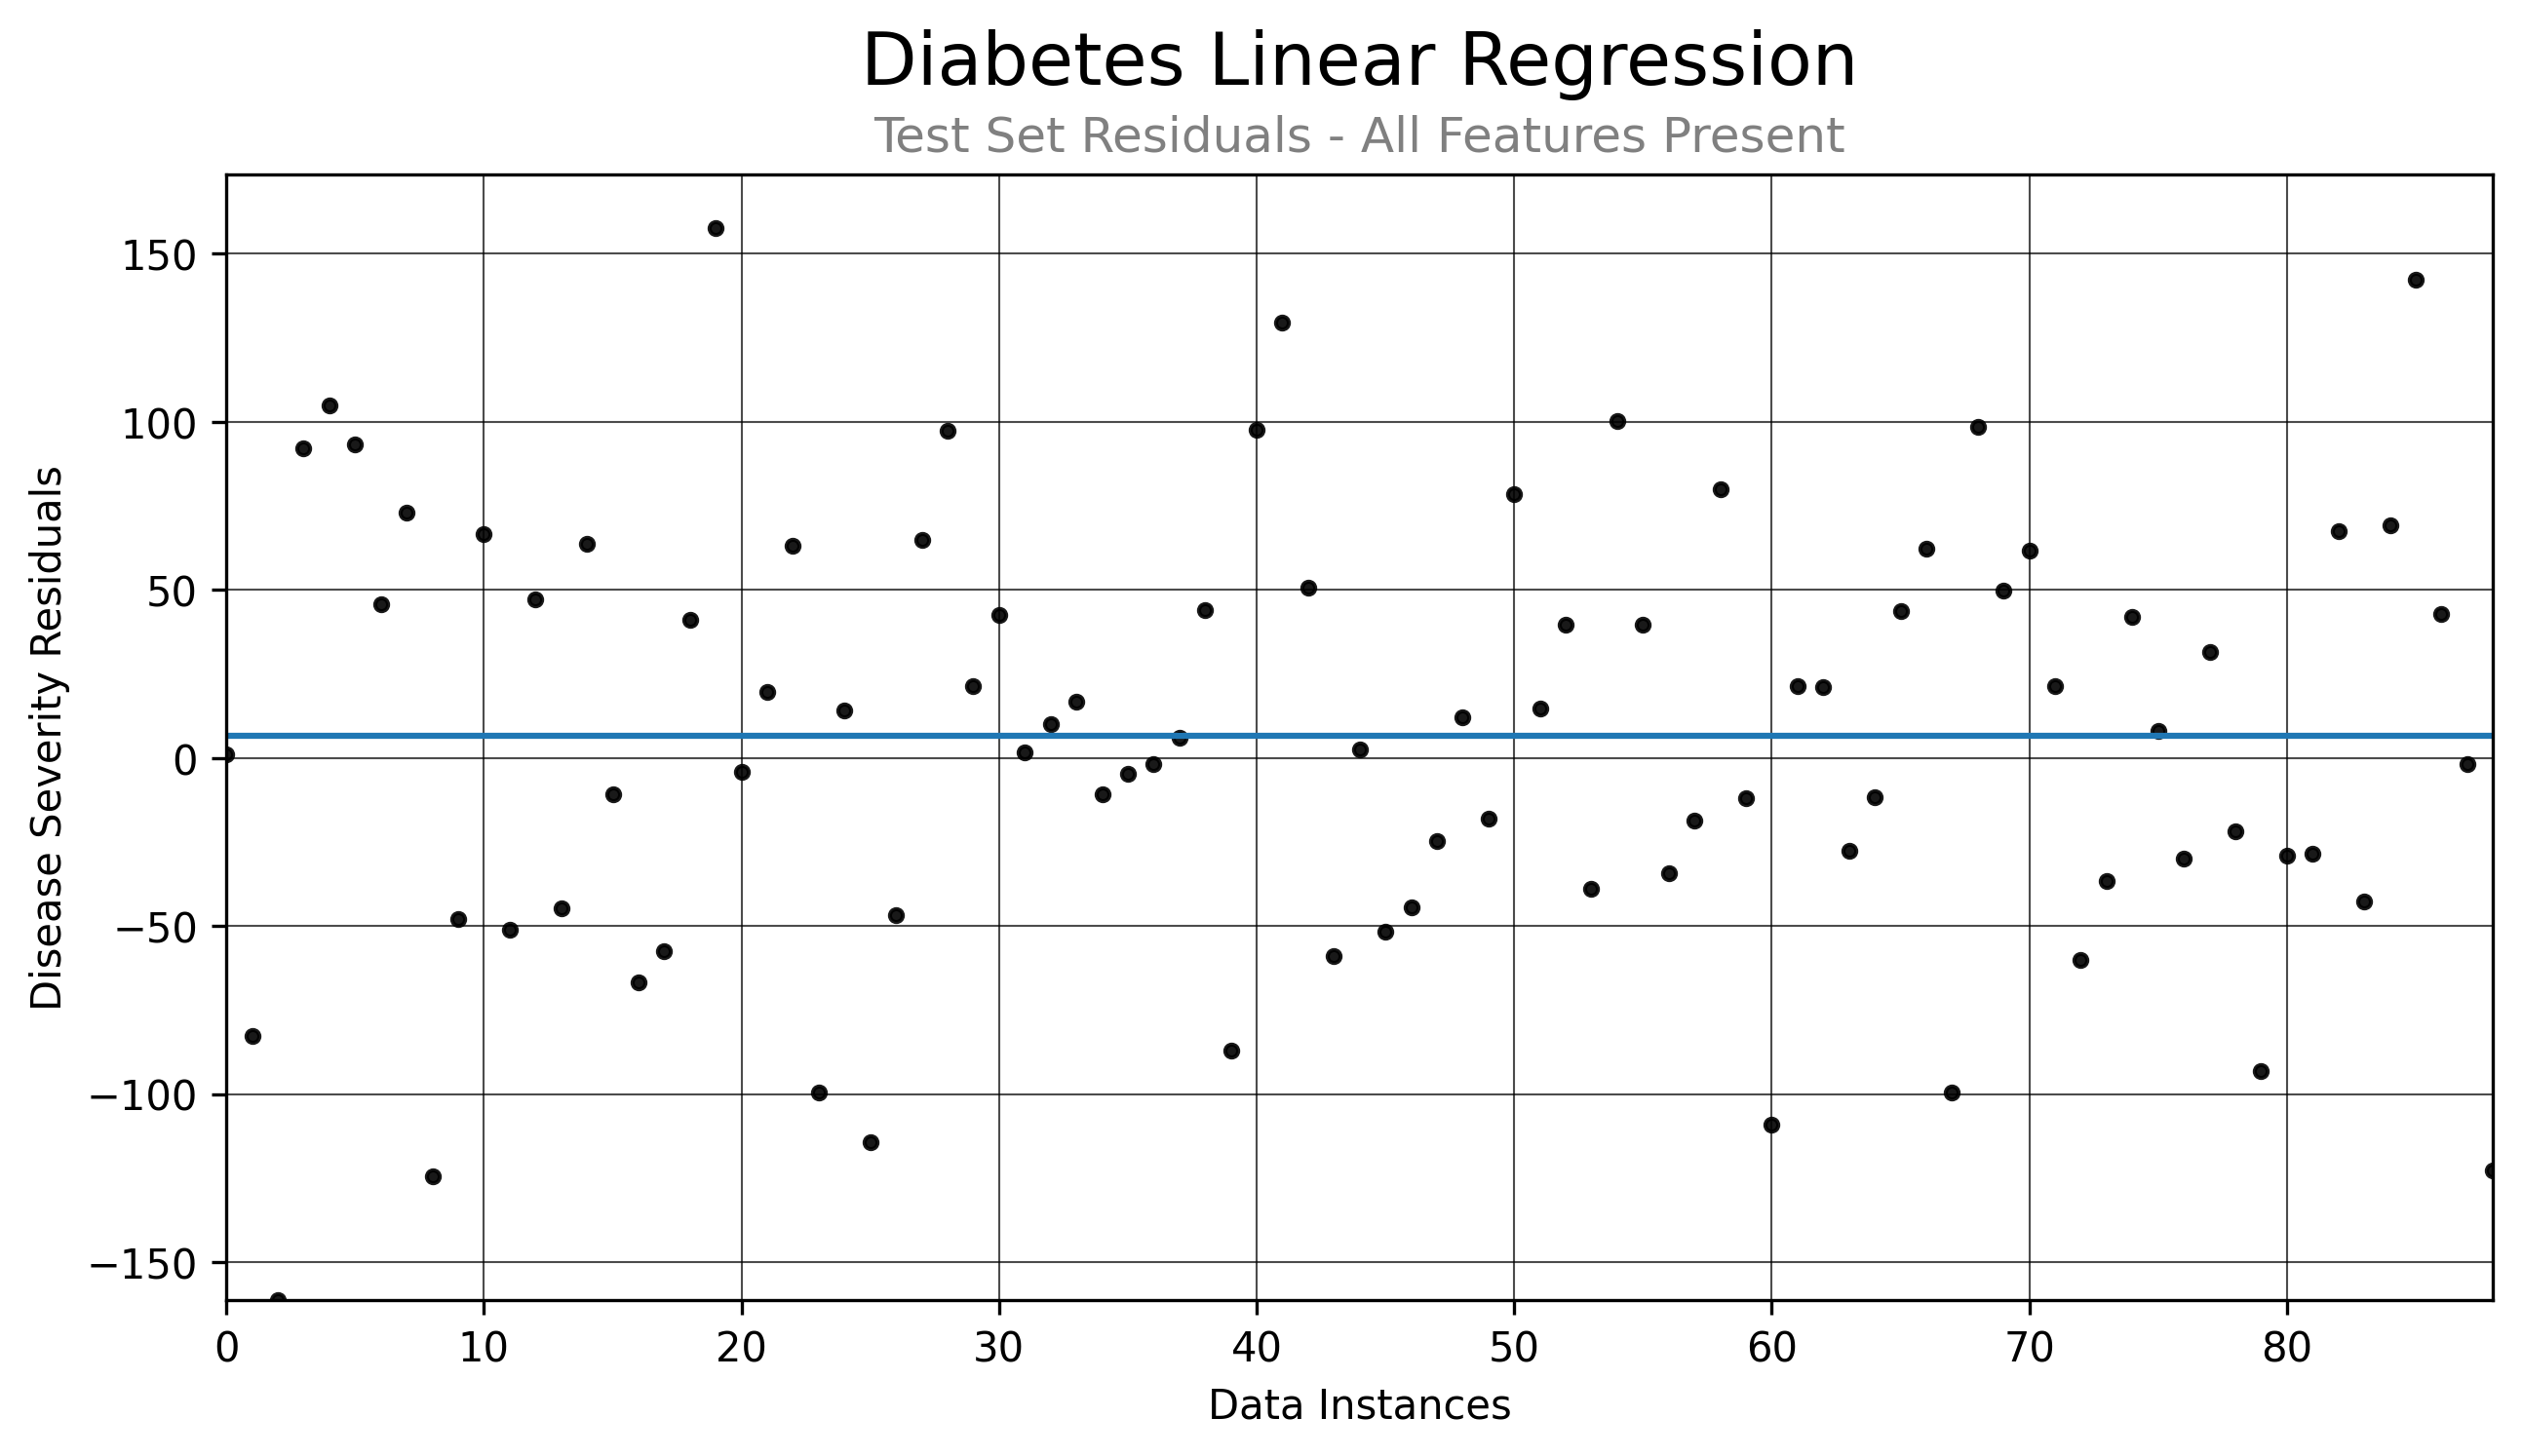

In [6]:
# Step 1. Train a linear regression model on the training set
model = LinearRegression()
model.fit(X_train, y_train)

# Step 2. Evaluate the model on the test set using R^2 score.
y_pred = model.predict(X_test)
print(f'R^2: {r2_score(y_test, y_pred):.4f}')

resids = y_test-y_pred
fig, ax = compareScatter(x_list=range(n_testing),
             y_lists=[resids],
             title="Diabetes Linear Regression",
             subtitle="Test Set Residuals - All Features Present",
             xlabel="Data Instances",
             ylabel="Disease Severity Residuals",
             show=False, save=False)
ax.hlines(np.mean(resids), 0, n_testing-1)
plt.show()

## Task 3: Implement Recursive Feature Elimination (RFE)

In [7]:
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
# Step 1. Perform RFE using the linear regression model as the base estimator.
# The model is still saved from the previous steps
mse_scores = []
coefs = []
r2_scores = []
initial_feature_ranking = []

# Step 2. Start with all 10 features and iteratively eliminate the least important feature until only one feature remains.
for i in range(len(features), 0, -1):
    rfe = RFE(estimator=model, n_features_to_select=i, step=1)
    rfe.fit(X_train, y_train)

    current_features = X_train.columns[rfe.support_] 

    feature_removed = [f for f in features if f not in current_features and f not in initial_feature_ranking]
    if (len(feature_removed) > 0):
        initial_feature_ranking.append(feature_removed[0])
    
    X_reduced = X_train[current_features]
    model.fit(X_reduced, y_train)
    y_pred = model.predict(X_reduced)

    # Step 3. Track the R^2 score at each iteration and the coefficients for each feature.
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)
    coefs.append(model.coef_)

    # print(model.coef_)

    print(f"Iteration {len(features)-i}:")
    print(f"  MSE: {mse:.4f}\n  R^2: {r2:.4f}")
    print(f"  Features used:")
    for attr, coef in zip(list(current_features), list(model.coef_)):
        print(f"    {attr}: {coef:.2f}")

# Only one feature should be left
leftover_features = [f for f in features if f not in initial_feature_ranking]
# Add it to the end of our initial feature ranking
initial_feature_ranking.append(leftover_features[0])
# Reverse the list so first is best
initial_feature_ranking = initial_feature_ranking[::-1]


Iteration 0:
  MSE: 2556.2977
  R^2: 0.5583
  Features used:
    age: 1.16
    sex: -11.14
    bmi: 26.57
    bp: 14.43
    s1: -48.27
    s2: 27.44
    s3: 7.99
    s4: 8.95
    s5: 41.20
    s6: 0.87
Iteration 1:
  MSE: 2556.8008
  R^2: 0.5582
  Features used:
    age: 1.27
    sex: -11.05
    bmi: 26.70
    bp: 14.62
    s1: -48.14
    s2: 27.36
    s3: 7.96
    s4: 9.05
    s5: 41.33
Iteration 2:
  MSE: 2558.1025
  R^2: 0.5580
  Features used:
    sex: -10.95
    bmi: 26.80
    bp: 14.86
    s1: -48.35
    s2: 27.73
    s3: 8.12
    s4: 9.02
    s5: 41.62
Iteration 3:
  MSE: 2562.7494
  R^2: 0.5572
  Features used:
    sex: -10.99
    bmi: 26.62
    bp: 14.88
    s1: -34.66
    s2: 18.21
    s4: 4.65
    s5: 37.04
Iteration 4:
  MSE: 2567.3131
  R^2: 0.5564
  Features used:
    sex: -10.61
    bmi: 26.60
    bp: 14.72
    s1: -39.60
    s2: 24.58
    s5: 40.44
Iteration 5:
  MSE: 2659.4224
  R^2: 0.5405
  Features used:
    bmi: 28.34
    bp: 12.17
    s1: -29.54
    s2: 15.34
    

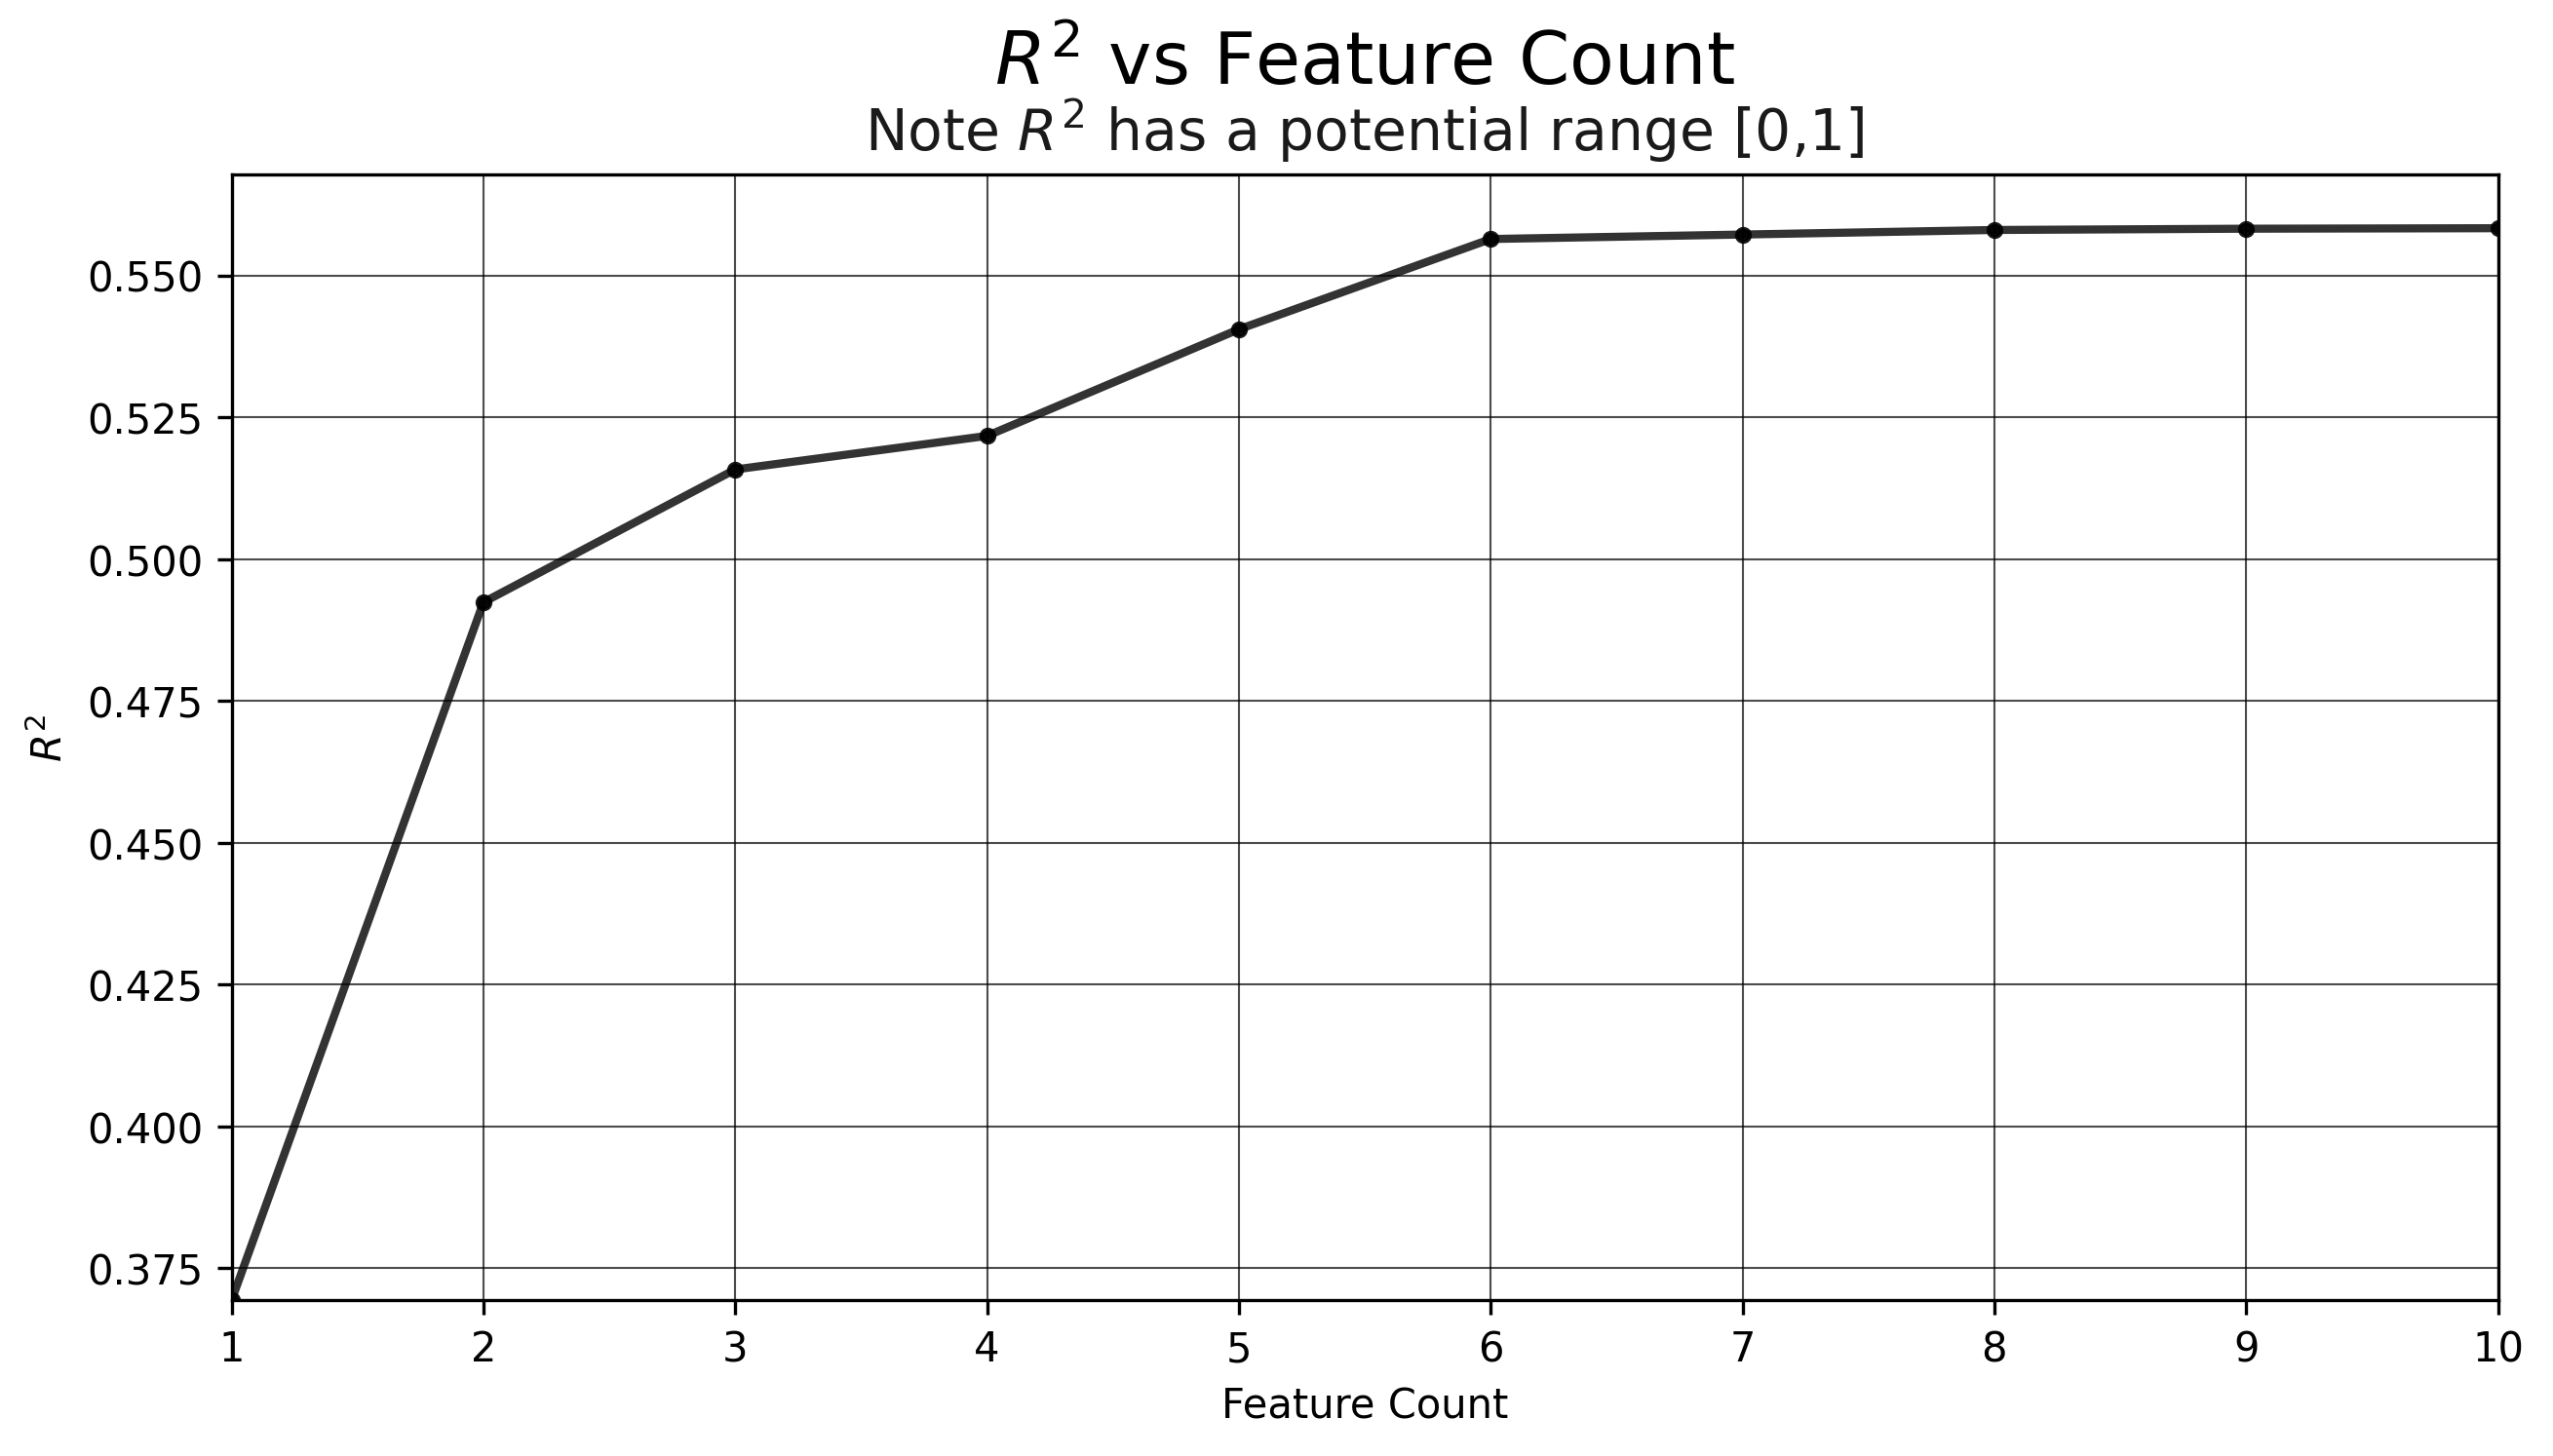

In [8]:
# Step 4. Visualize the R^2 score as a function of the number of retained features.
feature_counts = [len(x) for x in coefs]
compareLines(x_list=feature_counts,
             y_lists=[r2_scores],
             title=r"$R^2$ vs Feature Count",
             subtitle=r"Note $R^2$ has a potential range [0,1]",
             xlabel="Feature Count",
             ylabel=r"$R^2$")


In [9]:
# Step 5. Identify the optimal number of features using a threshold for significant R^2 improvement (e.g., 0.01).
threshold = 0.01
backwards_r2 = r2_scores[::-1]
prev_r2 = backwards_r2[0]
n_features_to_select = 1
print(f"n_features: 1, r2: {prev_r2:.4f}")
for i, r2 in enumerate(backwards_r2[1::], 1):
    print(f"n_features: {i+1}, r2: {r2:.4f}")
    if (r2-prev_r2 <= threshold):
        print(f"    R^2 Improvement:{r2-prev_r2:.4f}")
        print(f"    Optimal number of features is {i}.")
        n_features_to_select = i
        break
    prev_r2 = r2

n_features: 1, r2: 0.3693
n_features: 2, r2: 0.4924
n_features: 3, r2: 0.5158
n_features: 4, r2: 0.5217
    R^2 Improvement:0.0059
    Optimal number of features is 3.


## Task 4: Analyze Feature Importance

In [10]:
# Thank you!
class CustomRFE:
    def __init__(self, estimator, n_features_to_select):
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select
        self.coefficient_history = []
        self.eliminated_features = []

    def fit(self, X, y, feature_names):
        X_current = X.copy()
        features_remaining = list(range(X.shape[1]))
        
        while len(features_remaining) > self.n_features_to_select:
            # Fit linear regression
            self.estimator.fit(X_current, y)
            
            # Record current coefficients
            current_coefs = np.zeros(len(feature_names))
            current_coefs[features_remaining] = self.estimator.coef_
            self.coefficient_history.append(current_coefs)
            
            # Get absolute coefficient values for remaining features
            coef_abs = np.abs(self.estimator.coef_)
            
            # Find the feature with smallest absolute coefficient
            min_coef_idx = np.argmin(coef_abs)
            eliminated_feature_idx = features_remaining[min_coef_idx]
            
            # Track eliminated feature
            self.eliminated_features.append(feature_names[eliminated_feature_idx])
            
            # Remove the feature with smallest coefficient
            features_remaining.pop(min_coef_idx)
            X_current = X[:, features_remaining]
        
        return self

# Step 1. Create a table showing the coefficients of each feature at each iteration of RFE.
custom_rfe = CustomRFE(model, n_features_to_select=n_features_to_select-1)

custom_rfe.fit(X_train.values, y_train, diabetes.feature_names)

coef_df = pd.DataFrame(
    custom_rfe.coefficient_history, 
    columns=diabetes.feature_names
)

print("Coefficient Values Across RFE Iterations:")
print(coef_df.round(4))

print("\nEliminated Features Order:")
for i, feature in enumerate(custom_rfe.eliminated_features, 1):
    print(f"Iteration {i}: {feature}")

# custom_rfe.coefficient_history

Coefficient Values Across RFE Iterations:
      age      sex      bmi       bp       s1       s2      s3      s4  \
0  1.1561 -11.1431  26.5741  14.4312 -48.2702  27.4404  7.9864  8.9549   
1  1.2670 -11.0468  26.7022  14.6201 -48.1438  27.3644  7.9577  9.0459   
2  0.0000 -10.9472  26.8039  14.8610 -48.3506  27.7264  8.1234  9.0244   
3  0.0000 -10.9869  26.6203  14.8785 -34.6644  18.2074  0.0000  4.6529   
4  0.0000 -10.6118  26.5976  14.7243 -39.6034  24.5795  0.0000  0.0000   
5  0.0000   0.0000  28.3355  12.1726 -29.5422  15.3376  0.0000  0.0000   
6  0.0000   0.0000  32.7421   0.0000 -27.9270  14.5609  0.0000  0.0000   
7  0.0000   0.0000  34.7874   0.0000 -13.5410   0.0000  0.0000  0.0000   

        s5      s6  
0  41.2033  0.8718  
1  41.3307  0.0000  
2  41.6152  0.0000  
3  37.0360  0.0000  
4  40.4360  0.0000  
5  36.9511  0.0000  
6  39.6833  0.0000  
7  35.7280  0.0000  

Eliminated Features Order:
Iteration 1: s6
Iteration 2: age
Iteration 3: s3
Iteration 4: s4
Iteration

In [11]:
# Step 2. Discuss the three most important features and their significance in predicting the target variable
important_features = [x for x in diabetes.feature_names if (x not in custom_rfe.eliminated_features[~-1]) ]
print(f"\nMost important features and their coefficients:")

for feature in important_features:
    this_coef = coef_df[feature][len(coef_df[feature])-1]
    if (this_coef != 0):
        print(f"  {feature}: {this_coef:.4f}")

# Step 3. Compare the initial feature ranking with the final set of selected features.
print("Initial feature ranking:")
for i, f in enumerate(initial_feature_ranking):
    print(f"{i+1}: {f} ", end="")
    if (i < n_features_to_select):
        print(f" ({coefs[len(coefs)-n_features_to_select][i]:.4f})", end="")
    print("")


Most important features and their coefficients:
  bmi: 34.7874
  s1: -13.5410
  s5: 35.7280
Initial feature ranking:
1: bmi  (34.7874)
2: s5  (-13.5410)
3: s1  (35.7280)
4: s2 
5: bp 
6: sex 
7: s4 
8: s3 
9: age 
10: s6 


The final and initial feature rankings contain the same set of features with the same weights. 

Using a custom class to perform this process is much more elegant than the original method, and gives results which are much easier to extract. 


## Task 5: Reflection

### What did you learn about feature selection using RFE?

Feature selection using RFE is a neat process, and is a very straightforward way to narrow down our feature selection to focus on the factors that matter most.

RFE helps to provide a clearer direction for further study, and also helps reducing the dimensional complexity of the dataset while removing the least useful features.

### How does RFE compare to other feature selection methods like LASSO in terms of methodology and results?

RFE exists outside of a model, and is more like a tool to get information about how the model could be simplified while maximizing R^2.

LASSO, on the other hand, is built into a model, and explicitly changes the coefficients of features based on their importance. 

In LASSO, the feature removal is like a byproduct of its broader usefulness, whereas RFE exists only to remove features.

### What insights can you draw about the dataset from the selected features?

Our results make intuitive sense: 
- BMI is a weight indicator, which we would expect to be highly correlated with diabetes. 
- s1 represents cholesterol levels, which is also intuitively known to be correlated with diabetes. 
- s5 is our final pick, and what's interesting is that in the dataset description, s5 is defined as "possibly log of serum triglycerides level", which seems to imply that the meaning of s5 is potentially unknown. Regardless, it is the only one of our selected features with a negative coefficient, implying that higher serum triglyceride levels may be correlated with lower diabetes severity.

